In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
sc = StandardScaler()
pd_xela_allfiles = pd.read_csv('data.csv', index_col=0)
pd_sliplabel_allfiles = pd.read_csv('labels.csv', index_col=0)

data = pd_xela_allfiles.to_numpy()
data = sc.fit_transform(data)
labels = pd_sliplabel_allfiles.to_numpy()
(data.shape, labels.shape)

((229651, 48), (229651, 1))

<AxesSubplot: title={'center': 'mm'}>

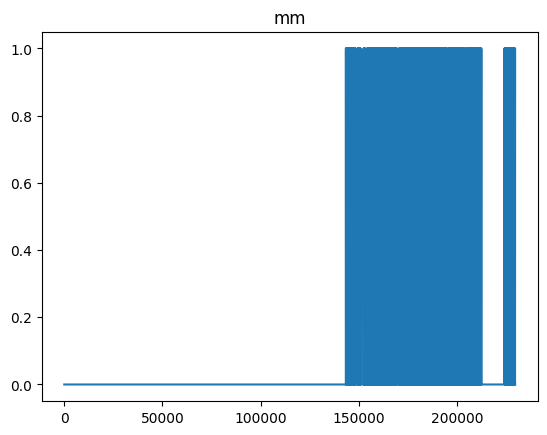

In [ ]:
# plt.style.use('ggplot')
pd_sliplabel_allfiles['slip'].plot(label='CLOSE', title='mm')

In [4]:
seq = 10
x = []
for t in range(data.shape[0]-(seq-1)):
    x.append(data[t:t+seq])
x = np.array(x)
y = labels[seq-1:]

(x.shape, 
y.shape)

((229647, 5, 48), (229647, 1))

In [5]:
X_train_tensors = Variable(torch.Tensor(x))
y_train_tensors = Variable(torch.Tensor(y))
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], seq, 48))

print(X_train_tensors.shape, X_train_tensors_final.shape)

torch.Size([229647, 5, 48]) torch.Size([229647, 5, 48])


In [6]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, num_classes) 

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        out = self.sigmoid(out)
        return out

In [7]:
num_epochs = 100
learning_rate = 0.003 

input_size = 48
hidden_size = 32
num_layers = 1 
num_classes = 1 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])
criterion = torch.nn.BCELoss()   
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [8]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step() 
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.65542
Epoch: 1, loss: 0.63817
Epoch: 2, loss: 0.62127
Epoch: 3, loss: 0.60429
Epoch: 4, loss: 0.58714
Epoch: 5, loss: 0.56940
Epoch: 6, loss: 0.55076
Epoch: 7, loss: 0.53114
Epoch: 8, loss: 0.51062
Epoch: 9, loss: 0.48935
Epoch: 10, loss: 0.46751
Epoch: 11, loss: 0.44534
Epoch: 12, loss: 0.42297
Epoch: 13, loss: 0.40064
Epoch: 14, loss: 0.37852
Epoch: 15, loss: 0.35695
Epoch: 16, loss: 0.33628
Epoch: 17, loss: 0.31689
Epoch: 18, loss: 0.29903
Epoch: 19, loss: 0.28288
Epoch: 20, loss: 0.26849
Epoch: 21, loss: 0.25586
Epoch: 22, loss: 0.24490
Epoch: 23, loss: 0.23542
Epoch: 24, loss: 0.22717
Epoch: 25, loss: 0.21987
Epoch: 26, loss: 0.21330
Epoch: 27, loss: 0.20732
Epoch: 28, loss: 0.20182
Epoch: 29, loss: 0.19673
Epoch: 30, loss: 0.19204
Epoch: 31, loss: 0.18770
Epoch: 32, loss: 0.18375
Epoch: 33, loss: 0.18048
Epoch: 34, loss: 0.17698
Epoch: 35, loss: 0.17378
Epoch: 36, loss: 0.17088
Epoch: 37, loss: 0.16817
Epoch: 38, loss: 0.16557
Epoch: 39, loss: 0.16305
Epoch: 40,

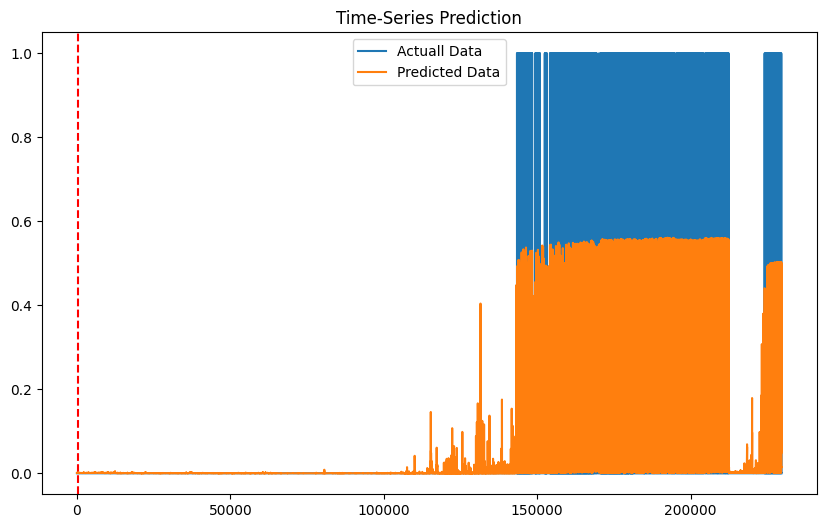

In [9]:
train_predict = lstm1(X_train_tensors_final)
data_predict = train_predict.data.numpy()
dataY_plot = y_train_tensors.data.numpy()

plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()